In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import numpy as np
import datetime
import plotly.express as px

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
# Import csv
df = pd.read_csv('..//data/cleaned_pets.csv')

C:\Users\Max-X1\AppData\Local\Temp\ipykernel_14704\1482904328.py:2: DtypeWarning: Columns (17,18,22,23,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('..//data/cleaned_pets.csv')


In [3]:
df.shape

(32758, 44)

In [4]:
# Subset data on only cats and dogs
df = df[df['species'].isin(['Cat', 'Dog'])]

# Check shape
print(df.shape)

# Check types
#df.dtypes

(32567, 44)


Additional Cleaning After Import

In [5]:
# Convert to datetime
df['published_at'] = pd.to_datetime(df['published_at'])
df['status_changed_at'] = pd.to_datetime(df['status_changed_at'])
df['published_date'] = pd.to_datetime(df['published_date'])
df['status_change_date'] = pd.to_datetime(df['status_change_date'])

In [6]:
# Add day of week column to dataframe for status change and published 
df['status_change_dow'] = df['status_change_date'].dt.day_name()
df['status_change_hour'] = df['status_changed_at'].dt.hour

df['published_dow'] = df['published_date'].dt.day_name()
df['published_hour'] = df['published_at'].dt.hour

In [7]:
# Define function to switch dtypes to string
def string_clean(column):
    x = df[column].astype('string')
    return x

# Switch objects to strings
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = string_clean(column)

In [8]:
# Check data types
#df.dtypes

## What are the key factors influencing the adoption dynamics for all animals listed for adoption in TN?

### Q1.How many animals were available at the end of 2023 vs how many were adopted in 2023?

In [9]:
# How many animals were available at the end of 2023 vs how many were adopted in 2023?
available = df[df['status'] == 'adoptable']
adopted = df[df['status'] == 'adopted']

print('listed animals:', df['id'].count())
print('available animals:', available['id'].count())
print('adopted animals:', adopted['id'].count())

listed animals: 32567
available animals: 2993
adopted animals: 29574


### Q2. What is the overall adoption rate for 2023?

In [10]:
# Count # of adoptions in adopted df and df - divide adopted by all pets and multiply * 100
overall_ar = round((adopted['id'].count() / df['id'].count()) * 100, 2)

print('Overall Average Adoption Rate:', overall_ar, '%')

Overall Average Adoption Rate: 90.81 %


### Q3. Are there specific species that are more likely to be adopted?

What is the distribution of cats and dogs in TN?

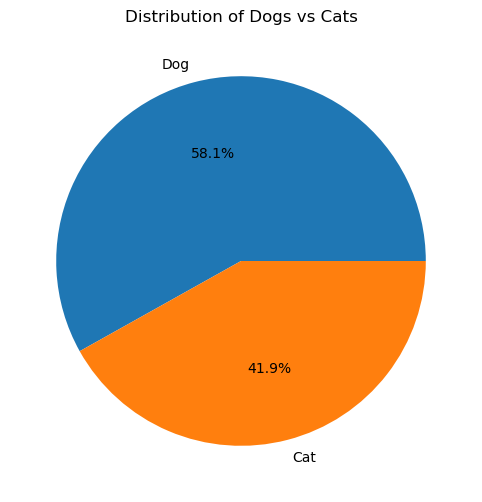

In [143]:
species_count = df['species'].value_counts()

plt.figure(figsize=(10, 6))

plt.pie(species_count, labels=species_count.index, autopct='%1.1f%%') 

plt.title('Distribution of Dogs vs Cats')

plt.show() 

How many animals of each species were listed on petfinder in 2023?

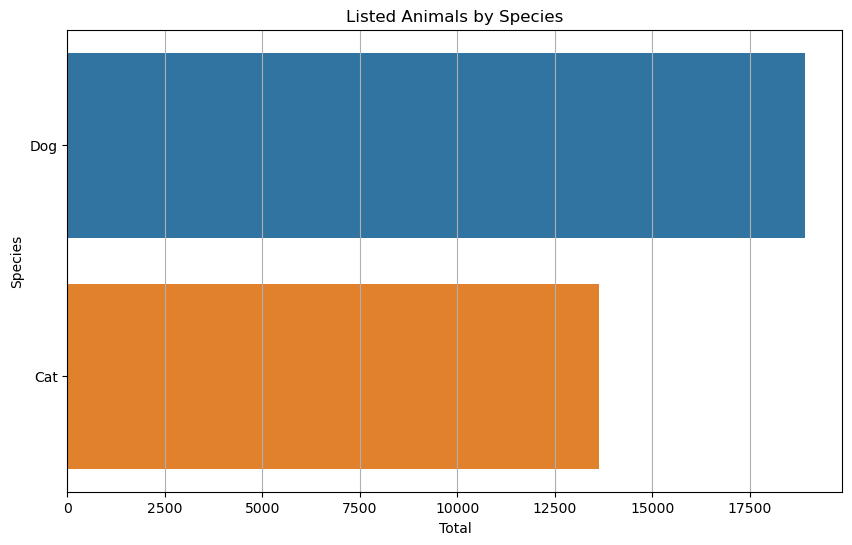

In [12]:
listed = df.groupby('species')['id'].count().reset_index(name='count').sort_values('count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='species', data=listed)
plt.title('Listed Animals by Species')
plt.xlabel('Total')
plt.ylabel('Species')

plt.grid(axis='x')

plt.show()

What types of animal species are available for adoption vs how many were adopted in 2023? What types of animals are listed the most frequently?

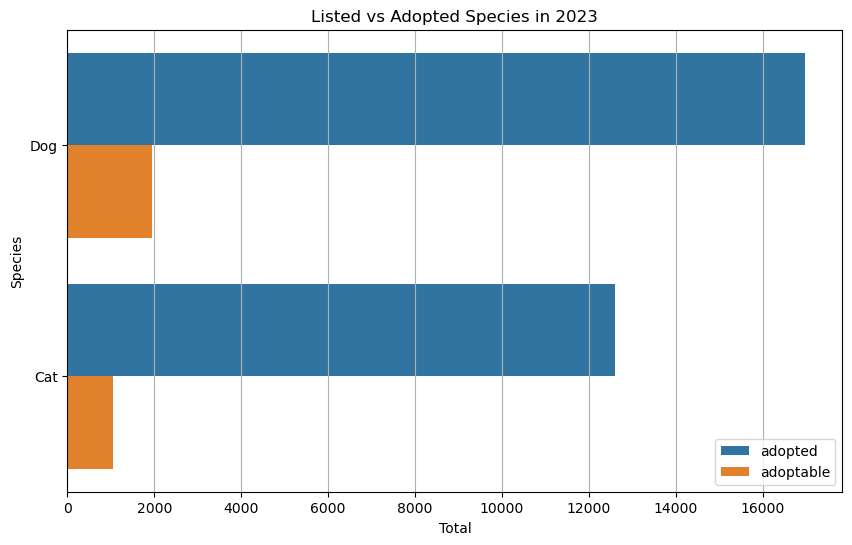

In [14]:
listed_vs_adopted = df.groupby(['species', 'status'])['id'].count().reset_index(name='count').sort_values('count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='species', data=listed_vs_adopted, hue='status')
plt.title('Listed vs Adopted Species in 2023')
plt.xlabel('Total')
plt.ylabel('Species')
plt.grid(axis='x')
plt.legend(loc='lower right')

plt.show()

#### What is the adoption rate by species? 

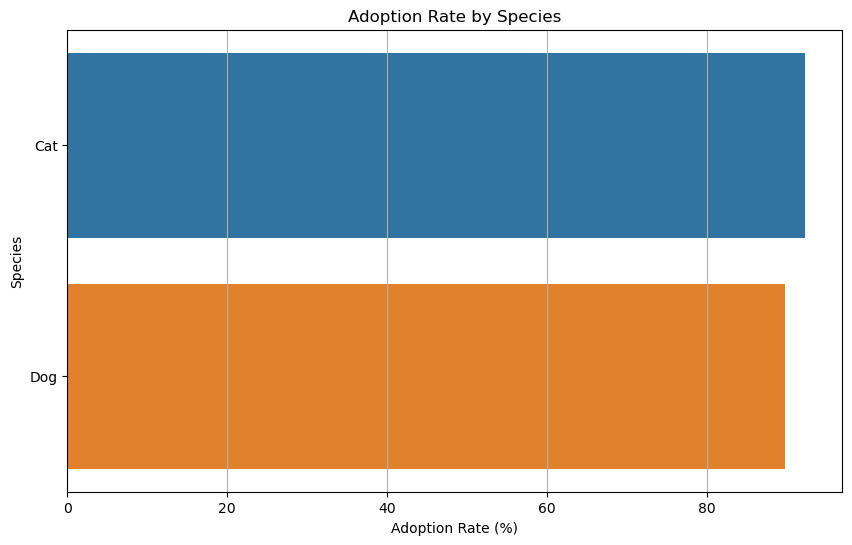

In [15]:
# Group and count for adopted and total
total_by_species = df.groupby('species')['id'].count().reset_index(name='count_total')
adopted_by_species = adopted.groupby('species')['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
species_ar = pd.merge(total_by_species, adopted_by_species, on='species', how='outer')

# Fill NaNs
species_ar['count_adopted'] = species_ar['count_adopted'].fillna(0)

# Add new column and calculate adoption rate + round
species_ar['adoption rate %'] = round((species_ar['count_adopted'] / species_ar['count_total']) * 100, 2)
species_ar = species_ar.sort_values('adoption rate %', ascending=False)



# Plot in barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='adoption rate %', y='species', data=species_ar)
plt.xlabel('Adoption Rate (%)')
plt.ylabel('Species')
plt.title('Adoption Rate by Species')
plt.grid(axis='x')

plt.show()

#Note: Cats have a higher adoption rate than dogs - there are more dogs

## Q3. Does age, gender, or size impact possibility for adoption?

What is the distribution of age by species for adopted animals?

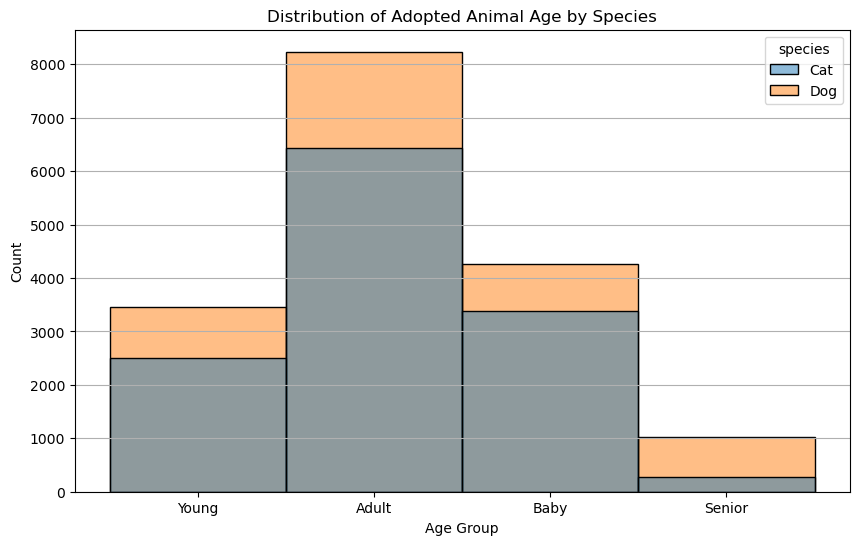

In [16]:
adopted = df[df['status'] == 'adopted']

plt.figure(figsize=(10, 6))
sns.histplot(data=adopted, x='age', hue='species')
plt.title('Distribution of Adopted Animal Age by Species')
plt.xlabel('Age Group')
plt.ylabel('Count')
#plt.yscale('log')
plt.grid(axis='y')

plt.show()

What is the adoption rate by age group? Which age groups have the highest and lowest adoption rates?

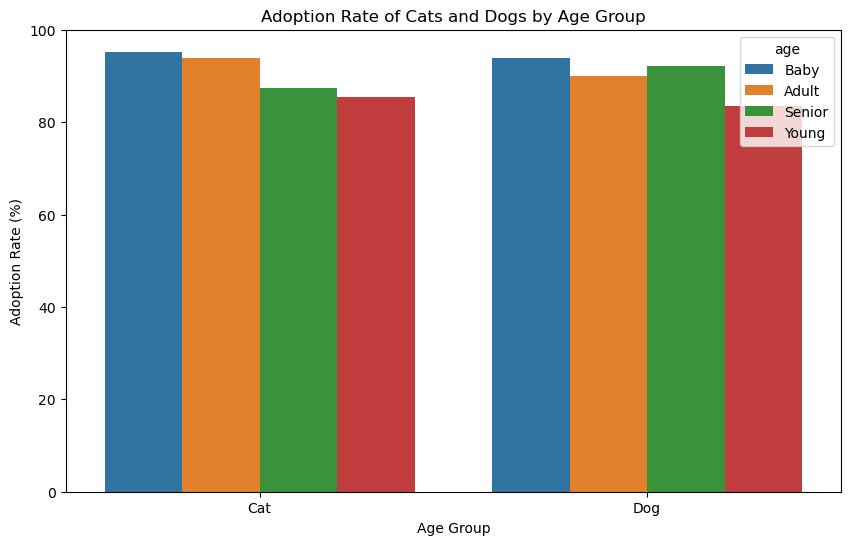

In [54]:
# Group and count for adopted and total
total_by_age = df.groupby(['species', 'age'])['id'].count().reset_index(name='count_total')
adopted_by_age = adopted.groupby(['species', 'age'])['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
age_ar = pd.merge(total_by_age, adopted_by_age, on=['species', 'age'], how='outer')

# Add new column and calculate adoption rate + round
age_ar['adoption rate %'] = round((age_ar['count_adopted'] / age_ar['count_total']) * 100, 2)
age_ar = age_ar.sort_values('adoption rate %', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=age_ar, x='species', y='adoption rate %', hue='age')
plt.title('Adoption Rate of Cats and Dogs by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Adoption Rate (%)')
plt.show()

# 'Young' age group has a lower adoption rate - What is considered young vs adult?

What is the distribution of gender by species?

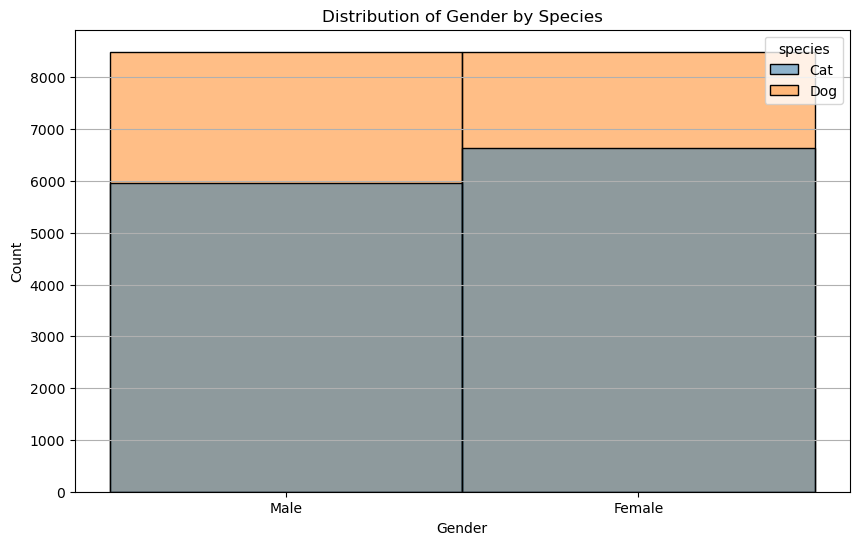

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data=adopted, x='gender', hue='species')
plt.title('Distribution of Gender by Species')
plt.xlabel('Gender')
plt.ylabel('Count')
#plt.yscale('log')
plt.grid(axis='y')

plt.show()

What is the adoption rate by gender group? Which gender groups have the highest and lowest adoption rates?

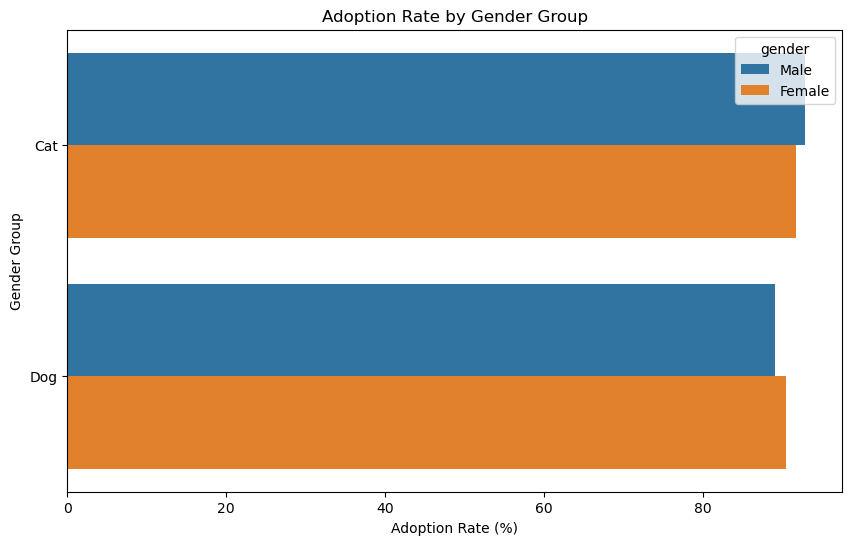

,species,gender,count_total,count_adopted,adoption rate %
1,Cat,Male,6418,5964,92.93
0,Cat,Female,7223,6628,91.76
2,Dog,Female,9395,8495,90.42
3,Dog,Male,9531,8487,89.05


In [53]:
# Group and count for adopted and total
total_by_gender = df.groupby(['species', 'gender'])['id'].count().reset_index(name='count_total')
adopted_by_gender = adopted.groupby(['species','gender'])['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
gender_ar = pd.merge(total_by_gender, adopted_by_gender, on=['species', 'gender'], how='outer')

# Add new column and calculate adoption rate + round
gender_ar['adoption rate %'] = round((gender_ar['count_adopted'] / gender_ar['count_total']) * 100, 2)

# Fill NaNs
gender_ar['count_adopted'] = gender_ar['count_adopted'].fillna(0)

gender_ar = gender_ar.sort_values('adoption rate %', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='adoption rate %', y='species', data=gender_ar, hue='gender')
plt.xlabel('Adoption Rate (%)')
plt.ylabel('Gender Group')
plt.title('Adoption Rate by Gender Group')
plt.show()

gender_ar

# Gender does not impact adoption rate
# Unknown genders are 1 reptile & 1 snake 

What is the distribution of size group by species?

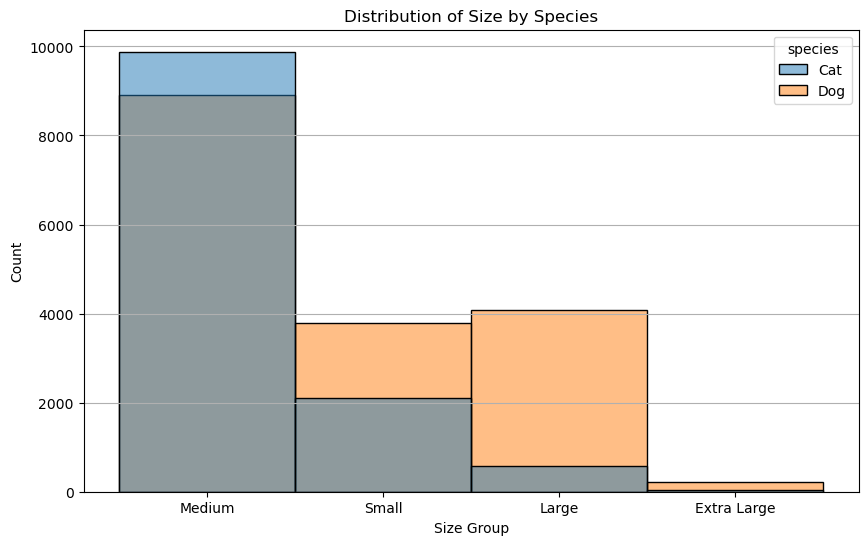

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(data=adopted, x='size', hue='species')
plt.title('Distribution of Size by Species')
plt.xlabel('Size Group')
plt.ylabel('Count')
#plt.yscale('log')
plt.grid(axis='y')

plt.show()

What is the adoption rate by size group? Which size groups have the highest and lowest adoption rates?

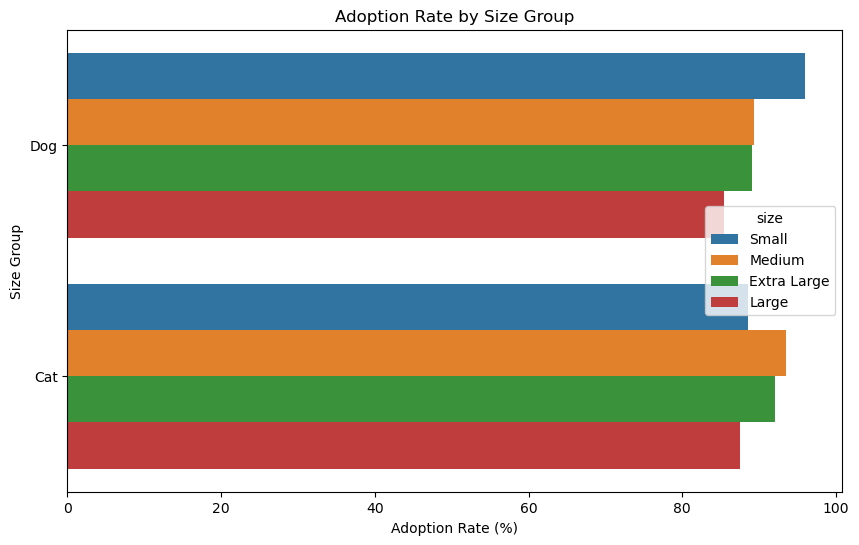

,species,size,count_total,count_adopted,adoption rate %
7,Dog,Small,3934,3778,96.03
2,Cat,Medium,10574,9881,93.45
0,Cat,Extra Large,38,35,92.11
6,Dog,Medium,9971,8904,89.30
4,Dog,Extra Large,247,220,89.07
3,Cat,Small,2366,2096,88.59
1,Cat,Large,663,580,87.48
5,Dog,Large,4774,4080,85.46


In [52]:
# Group and count for adopted and total
total_by_size = df.groupby(['species', 'size'])['id'].count().reset_index(name='count_total')
adopted_by_size = adopted.groupby(['species', 'size'])['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
size_ar = pd.merge(total_by_size, adopted_by_size, on=['species', 'size'], how='outer')

# Add new column and calculate adoption rate + round
size_ar['adoption rate %'] = round((size_ar['count_adopted'] / size_ar['count_total']) * 100, 2)
size_ar = size_ar.sort_values('adoption rate %', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='adoption rate %', y='species', data=size_ar, hue='size')
plt.xlabel('Adoption Rate (%)')
plt.ylabel('Size Group')
plt.title('Adoption Rate by Size Group')
plt.show()

size_ar

# Smaller dogs are slightly more likely to be adopted

## Q4. Are there patterns or trends related to how quickly an animal is adopted in TN? 

What is the overall average adoption speed?

In [55]:
avg_at = round(adopted['adoption_time'].mean())
print('Average Adoption Time:', avg_at, 'days')

Average Adoption Time: 17 days


What is the average adoption rate by species?

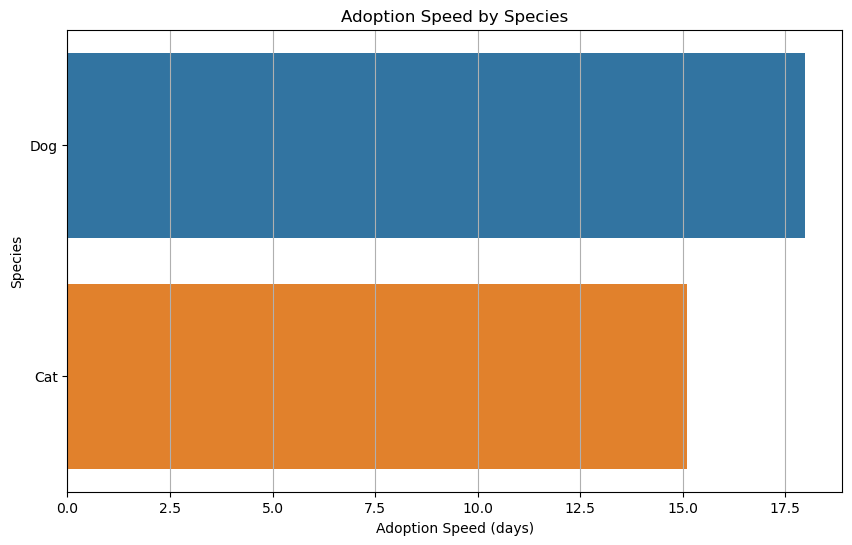

In [56]:
species_at = adopted.groupby('species')['adoption_time'].mean().reset_index(name='Avg Adoption Time').sort_values('Avg Adoption Time', ascending=False)
species_at['Avg Adoption Time'] = round(species_at['Avg Adoption Time'], 2) 

plt.figure(figsize=(10, 6))
sns.barplot(x='Avg Adoption Time', y='species', data=species_at)
plt.xlabel('Adoption Speed (days)')
plt.ylabel('Species')
plt.title('Adoption Speed by Species')
plt.grid(axis='x')
plt.show()

# Cats are adopted faster than dogs

What is the distribution of adoption time?

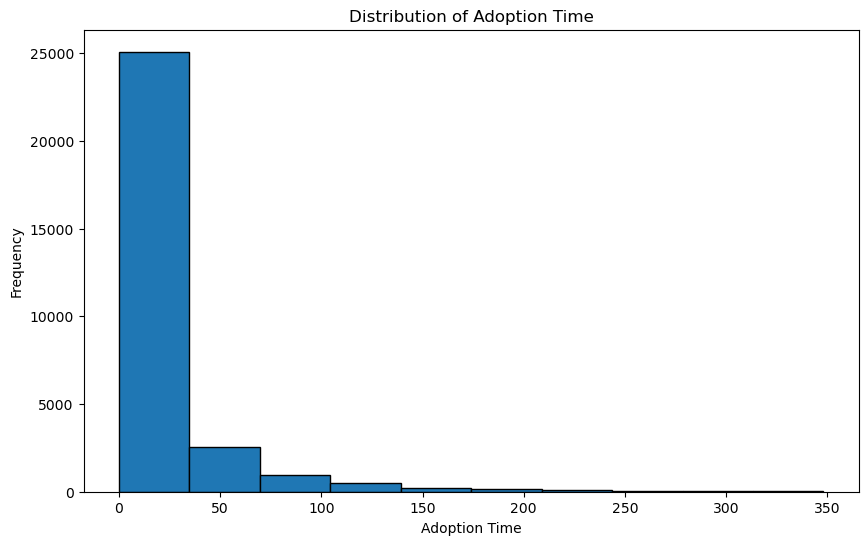

In [57]:
plt.figure(figsize=(10, 6))
plt.hist(adopted['adoption_time'], bins=10, edgecolor='black')
plt.xlabel('Adoption Time')
plt.ylabel('Frequency')
plt.title('Distribution of Adoption Time')
plt.show()

# Most animals are likely to be adopted between 0 and 50 days

Does an animals age impact adoption speed?

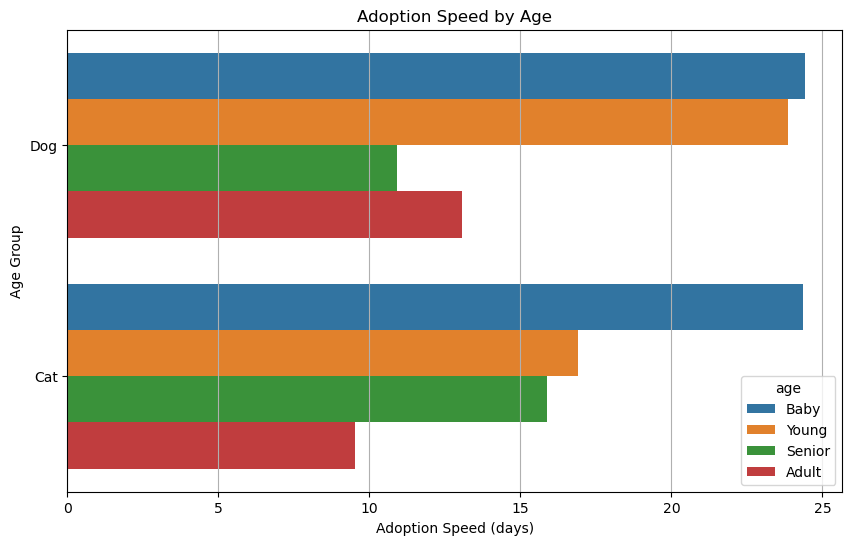

In [59]:
age_at = adopted.groupby(['species', 'age'])['adoption_time'].mean().reset_index(name='Avg Adoption Time').sort_values('Avg Adoption Time', ascending=False)
age_at['Avg Adoption Time'] = round(age_at['Avg Adoption Time'], 2) 

plt.figure(figsize=(10, 6))
sns.barplot(x='Avg Adoption Time', y='species', data=age_at, hue='age')
plt.xlabel('Adoption Speed (days)')
plt.ylabel('Age Group')
plt.title('Adoption Speed by Age')
plt.grid(axis='x')
plt.show()

# Senior dogs and adult cats are adopted faster than most age groups, which is surprising 

Does an animals gender impact adoption speed?

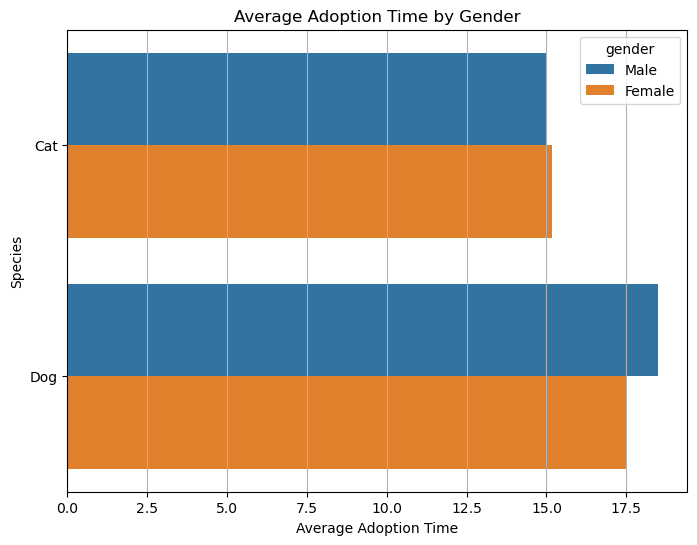

In [60]:
gender_at = adopted.groupby(['species', 'gender'])['adoption_time'].mean().reset_index(name='avg_at').sort_values('avg_at', ascending=True)

plt.figure(figsize=(8, 6))  
sns.barplot(x='avg_at', y='species', orient='h', data=gender_at, hue='gender')
plt.xlabel('Average Adoption Time')
plt.ylabel('Species')
plt.title('Average Adoption Time by Gender')
plt.grid(axis='x')
plt.show()

# Cat gender does not impact adoption speed, however, male dogs seem to have a slightly longer adoption speed

#### Does an animals size impact adoption speed?

Size vs Adoption Speed

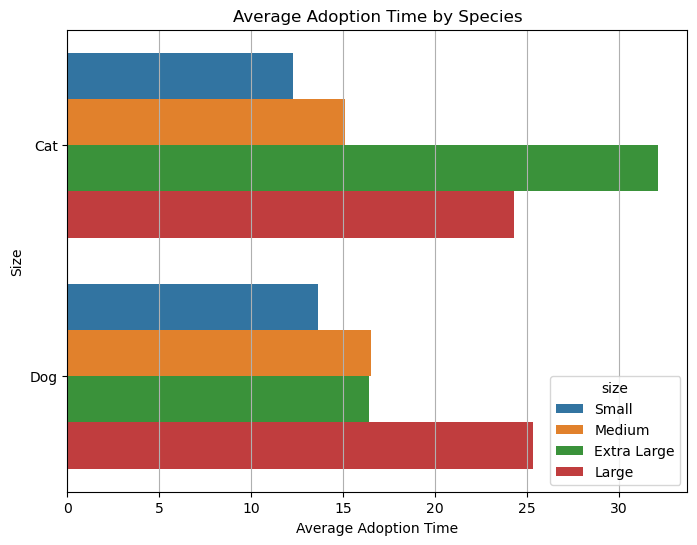

In [61]:
size_at = adopted.groupby(['species', 'size'])['adoption_time'].mean().reset_index(name='avg_at').sort_values('avg_at', ascending=True)

plt.figure(figsize=(8, 6))  
sns.barplot(x='avg_at', y='species', orient='h', data=size_at, hue='size')
plt.xlabel('Average Adoption Time')
plt.ylabel('Size')
plt.title('Average Adoption Time by Species')
plt.grid(axis='x')
plt.show()

# Smaller animals are adopted faster than extra large cats and large dogs

### Seasonality Trends

## Q5. Does seasonality impact adoption speed?

How does the number of listed pets compare to the number of pet adoptions on a monthly basis?

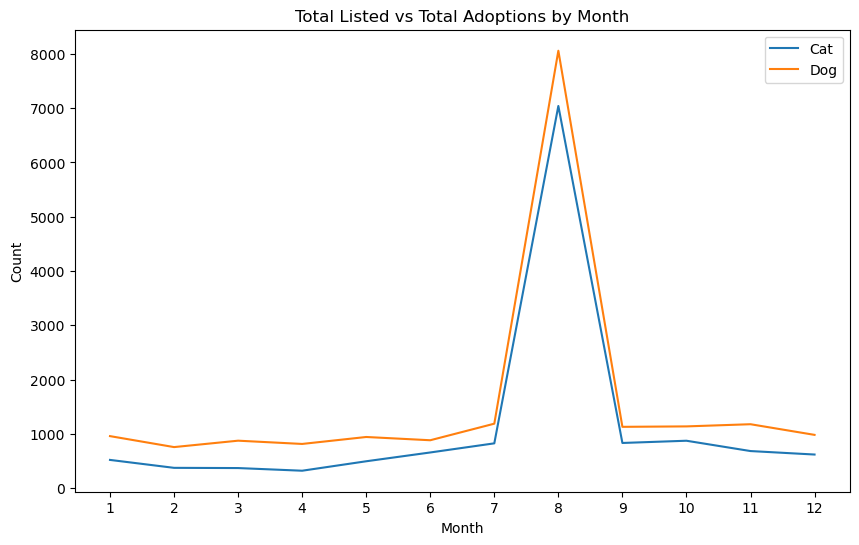

In [70]:
monthly_listed = df.groupby(['species', 'month_published'])['id'].count().reset_index(name='count')
monthly_adopted = adopted.groupby(['species', 'month_status_change'])['id'].count().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_listed, x='month_published', y='count', hue='species')
#sns.lineplot(data=monthly_adopted, x='month_status_change', y='count', hue='species')
plt.title('Total Listed vs Total Adoptions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(range(1, 13)) 
plt.legend()

plt.show()

# Note: The number of adopted pets increases slightly as the year goes on, and number of pets listed is consistent
# Note: There is a correlation between listed vs adopted 
# Note: There is a huge spike in listed/adopted pets between july and september (peaks in august)

What is the average adoption speed by month? Are there any trends?

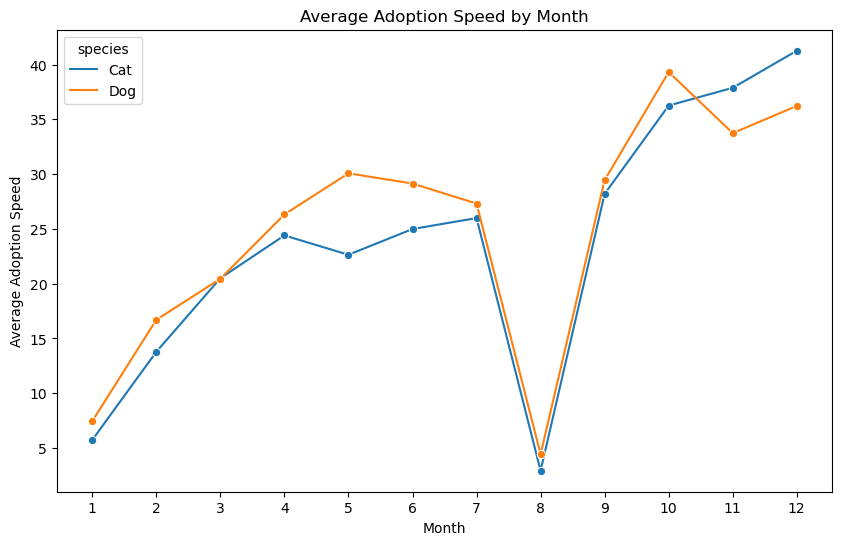

In [95]:
monthly_adoptions = adopted.groupby(['species', 'month_status_change'])['adoption_time'].mean().reset_index(name='avg_speed')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_adoptions, x='month_status_change', y='avg_speed', marker='o', hue='species')
plt.title('Average Adoption Speed by Month')
plt.xlabel('Month')
plt.ylabel('Average Adoption Speed')
plt.xticks(range(1, 13)) 
plt.show()


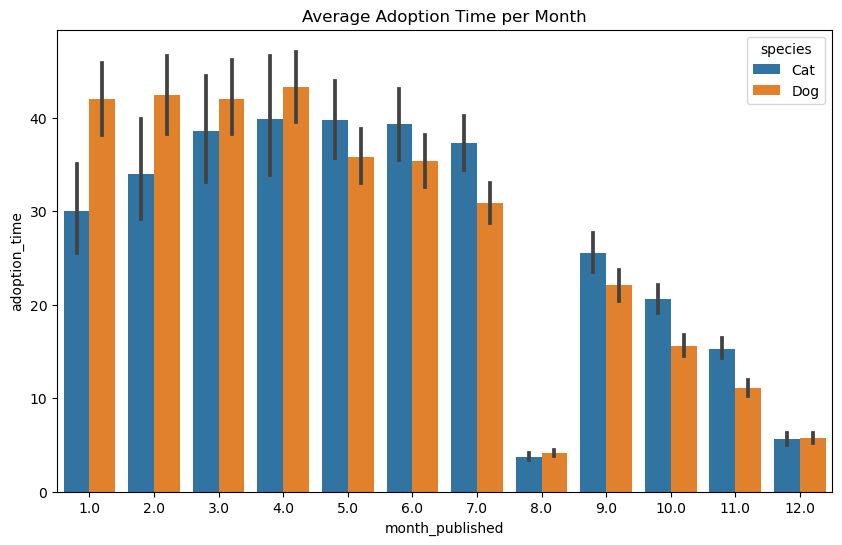

In [99]:
plt.figure(figsize=(10, 6))

sns.barplot(data=adopted, x='month_published', y='adoption_time', hue='species')
plt.title('Average Adoption Time per Month')
plt.show()

What is the relationship between adoption time and listing date for pet adoptions?

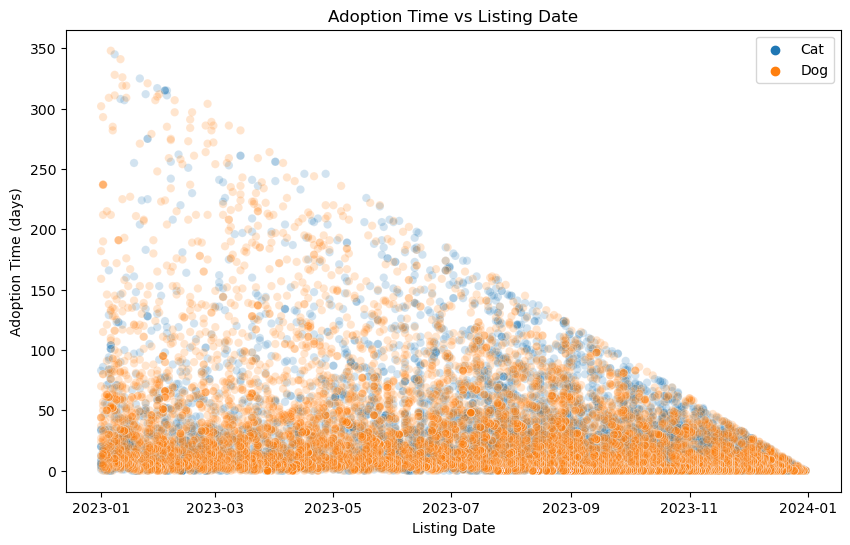

In [103]:
plt.figure(figsize=(10, 6))

# Plot adopted pets
sns.scatterplot(data=adopted, x='published_date', y='adoption_time', hue='species', alpha=0.2)

plt.title('Adoption Time vs Listing Date')
plt.ylabel('Adoption Time (days)')
plt.xlabel('Listing Date')

plt.legend()

plt.show()

# Animals tend to be adopted relatively quickly (between 0-50 days) and adoption time seems to decrease if pets are adopted as time goes on through the year

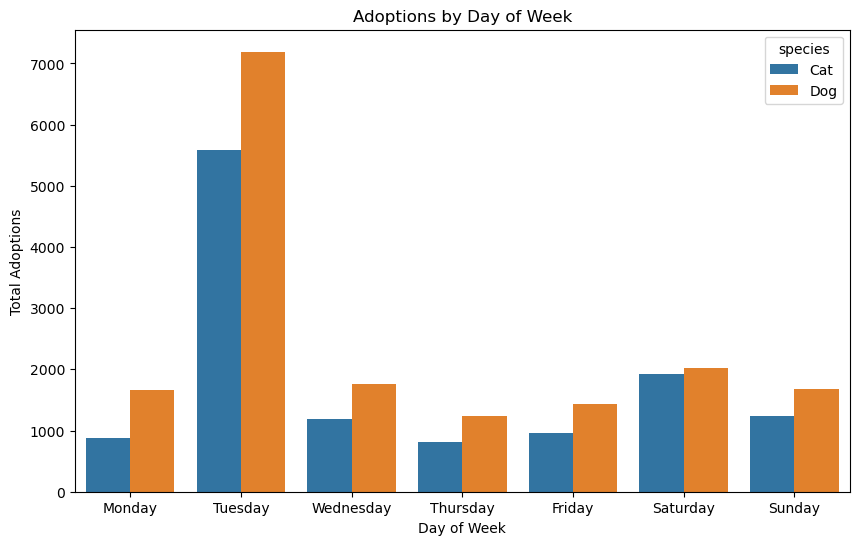

In [107]:
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.countplot(data=adopted, x='status_change_dow', order=order_list, hue='species')
plt.title('Adoptions by Day of Week')
plt.ylabel('Total Adoptions')
plt.xlabel('Day of Week')
plt.show()

# Tuesday's seem to be the most popular day for adoptions

Is there a trend in adoptions by day of the month?

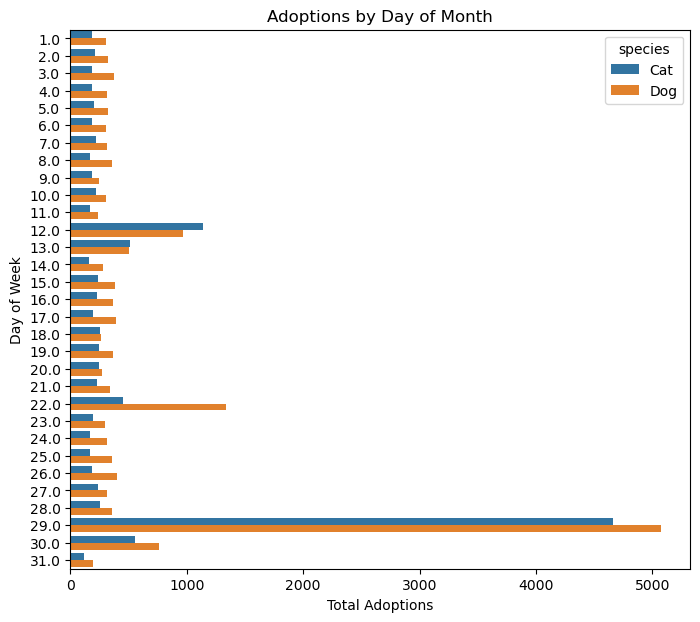

In [109]:
plt.figure(figsize=(8, 7))
sns.countplot(data=adopted, y='day_status_change', hue='species')
plt.title('Adoptions by Day of Month')
plt.ylabel('Day of Week')
plt.xlabel('Total Adoptions')
plt.show()

# Adoptions seem to spike towards the middle and the end of the month

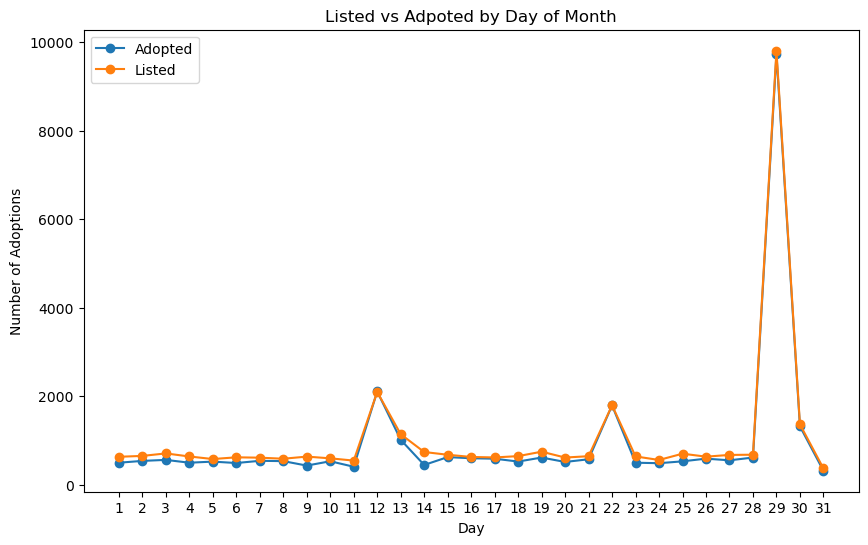

In [110]:
daily_adoptions = adopted.groupby('day_status_change')['id'].count()
daily_published = df.groupby('day_published')['id'].count()

plt.figure(figsize=(10, 6))

daily_adoptions.plot(kind='line', marker='o', label='Adopted')
daily_published.plot(kind='line', marker='o', label='Listed')

plt.title('Listed vs Adpoted by Day of Month')
plt.xlabel('Day')
plt.ylabel('Number of Adoptions')
plt.xticks(range(1, 32)) 
plt.legend()

plt.show()

# More animals are being listed than are being adopted each day of the month
# Peaks might be due to weekends, holidays, or paydays
# Peaks at end of the month might be due to pay days 

Why is there a spike in adoptions on the 29th of the month?

In [111]:
day_29 = adopted[(adopted['day_status_change'] == 29) & (adopted['status_change_dow'] == 'Tuesday')]

day_29.groupby(['status_change_dow', 'status_change_hour'])['id'].count()

# Most adoptions occured on Tuesday
# Adoption updates might be made on Tuesdays? 

status_change_dow  status_change_hour
Tuesday            0                        7
                   1                      106
                   2                       16
                   5                     5036
                   6                        1
                   8                        8
                   12                       2
                   13                       2
                   14                       2
                   16                       7
                   18                       2
                   19                    2861
                   20                       4
                   22                      10
                   23                    1188
Name: id, dtype: int64

#### Is there a specific time of year where animals are more likely to be adopted?

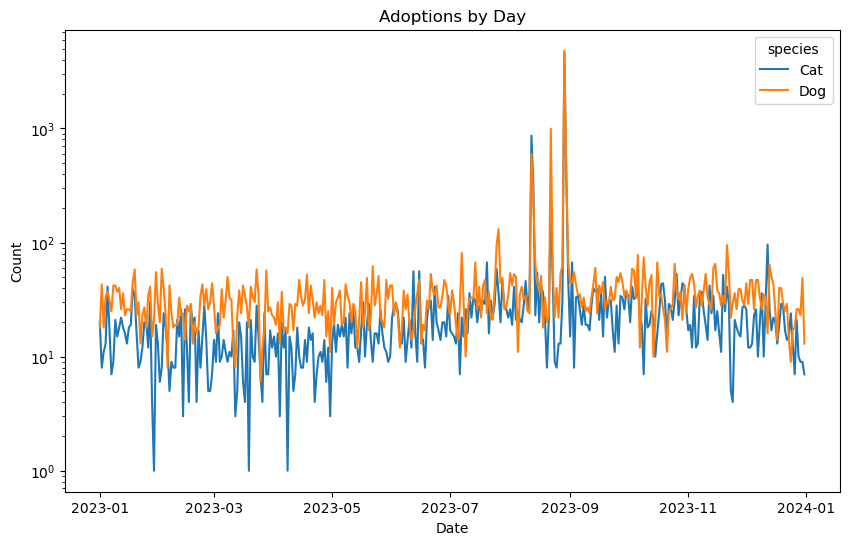

,species,status_change_date,count
0,Cat,2023-01-02,1
1,Cat,2023-01-03,1
2,Cat,2023-01-04,1
3,Cat,2023-01-05,7
4,Cat,2023-01-06,9
...,...,...,...
722,Dog,2023-12-27,25
723,Dog,2023-12-28,28
724,Dog,2023-12-29,33
725,Dog,2023-12-30,75


In [113]:
date_adoptions = adopted.groupby(['species', 'status_change_date'])['id'].count().reset_index(name='count')
date_published = df.groupby(['species', 'published_date'])['id'].count().reset_index(name='count')

date_adoptions['status_change_date'] = pd.to_datetime(date_adoptions['status_change_date'])

plt.figure(figsize=(10, 6))

sns.lineplot(x='published_date', y='count', data=date_published, hue='species')
plt.title('Adoptions by Day')
plt.xlabel('Date')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

date_adoptions

## Q6. How do adoption rates vary across different regions within TN?

How many cities in TN were animals available for adoptions?

In [114]:
df['contact.address.city'].nunique()

154

What is the adoption rate % per city?

In [115]:
# Group and count for adopted and total
total_by_city = df.groupby('contact.address.city')['id'].count().reset_index(name='count_total')
adopted_by_city = adopted.groupby('contact.address.city')['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
city_ar = pd.merge(total_by_city, adopted_by_city, on='contact.address.city', how='outer')

# Add new column and calculate adoption rate + round
city_ar['adoption rate %'] = round((city_ar['count_adopted'] / city_ar['count_total']) * 100, 2)
city_ar = city_ar.sort_values('count_total', ascending=False)

print(city_ar.head(10)) # Top 10 cities
print(city_ar.tail(10)) # Bottom 10

    contact.address.city  count_total  count_adopted  adoption rate %
59           Greeneville        10319        10281.0            99.63
131          Shelbyville         2079         2052.0            98.70
33            Crossville         1979         1841.0            93.03
104            Nashville         1890         1693.0            89.58
129          Sevierville          858          854.0            99.53
10           Blountville          763          741.0            97.12
20           Chattanooga          750          594.0            79.20
76             Knoxville          705          574.0            81.42
100         Mount Juliet          639          503.0            78.72
50              Franklin          620          516.0            83.23
    contact.address.city  count_total  count_adopted  adoption rate %
143              Telford            1            1.0            100.0
41                  Dyer            1            NaN              NaN
132      Signal Moun

What is the adoption rate per county?

In [116]:
# Import US Zips from https://simplemaps.com/data/us-zips
zipcodes = pd.read_csv('..//data/uszips.csv')
print(zipcodes.shape)
#zipcodes.head()

(33788, 18)


In [117]:
# Subset on state_name to get only TN data
zips = zipcodes[zipcodes['state_name'] == 'Tennessee']

# Count zips
zips['state_id'].count()

636

In [118]:
# Merge dataframes together on postcode
loc_df = pd.merge(df, zips, left_on='contact.address.postcode', right_on='zip', how='left')

In [119]:
# Drop unnecessary columns
drop = [
    'organization_id', 'url', 'tags', 'name', 
    'description', 'attributes.spayed_neutered',
    'attributes.house_trained', 'attributes.declawed',
    'attributes.special_needs', 'attributes.shots_current',
    'environment.children', 'environment.dogs', 'environment.cats', 
    'contact.address.state', 'zip', 'city', 'state_id', 'state_name', 
    'zcta', 'parent_zcta', 'county_fips',  
    'county_weights', 'county_fips_all', 'imprecise', 'military',
    'timezone'
]
loc_df.drop(drop, axis=1, inplace=True)

In [120]:
#loc_df.columns

In [121]:
total_by_county = loc_df.groupby('county_name')['id'].count().reset_index(name='count_total').sort_values('count_total', ascending=False)

adopted_loc = loc_df[loc_df['status'] == 'adopted']
adopted_by_county = adopted_loc.groupby('county_name')['id'].count().reset_index(name='count_adopted').sort_values('count_adopted', ascending=False)

# Merge two dataframes together
county_ar = pd.merge(total_by_county, adopted_by_county, on='county_name', how='outer')

# Add new column and calculate adoption rate + round
county_ar['adoption rate %'] = round((county_ar['count_adopted'] / county_ar['count_total']) * 100, 2)
county_ar = county_ar.sort_values('count_adopted', ascending=False)

print(county_ar.head(10)) # Top 10
print(county_ar.tail(10)) # Bottom 10 - Note - bottom 10 had no adoptions despite the number of animals

   county_name  count_total  count_adopted  adoption rate %
0       Greene        10335        10285.0            99.52
1     Davidson         2812         2548.0            90.61
2      Bedford         2071         2045.0            98.74
3       Shelby         1227         1011.0            82.40
5       Sevier          861          857.0            99.54
4     Sullivan          868          821.0            94.59
6    Jefferson          860          814.0            94.65
7       Wilson          807          662.0            82.03
9   Williamson          726          616.0            84.85
13   Claiborne          584          584.0           100.00
   county_name  count_total  count_adopted  adoption rate %
48      Carter           49            NaN              NaN
52        Rhea           33            NaN              NaN
56    Campbell           29            NaN              NaN
61     Lincoln           25            NaN              NaN
62       Lewis           20            N

By Region

In [122]:
# Put counties in respective regions manually into dictionary
# Copied from wiki https://en.wikipedia.org/wiki/Grand_Divisions_of_Tennessee
east = {
    'Anderson': 'East', 'Bledsoe': 'East', 'Blount': 'East', 'Bradley': 'East', 
    'Campbell': 'East', 'Carter': 'East', 'Claiborne': 'East','Cocke': 'East', 
    'Cumberland': 'East', 'Grainger': 'East', 'Greene': 'East', 'Hamblen': 'East',
    'Hamilton': 'East','Hancock': 'East','Hawkins': 'East', 'Jefferson': 'East', 
    'Johnson': 'East', 'Knox': 'East', 'Loudon': 'East', 'Marion': 'East', 
    'McMinn': 'East', 'Meigs': 'East', 'Monroe': 'East', 'Morgan': 'East',
    'Polk': 'East', 'Rhea': 'East', 'Roane': 'East', 'Scott': 'East', 
    'Sevier': 'East', 'Sullivan': 'East', 'Unicoi': 'East', 'Union': 'East', 
    'Washington': 'East'
}

middle = {
    'Bedford': 'Middle', 'Cannon': 'Middle', 'Cheatham': 'Middle', 'Clay': 'Middle',
    'Coffee': 'Middle', 'Davidson': 'Middle', 'DeKalb': 'Middle', 'Dickson': 'Middle',
    'Fentress': 'Middle', 'Franklin': 'Middle', 'Giles': 'Middle', 'Grundy': 'Middle',
    'Hickman': 'Middle', 'Houston': 'Middle', 'Humphreys': 'Middle', 'Jackson': 'Middle',
    'Lawrence': 'Middle', 'Lewis': 'Middle', 'Lincoln': 'Middle', 'Macon': 'Middle',
    'Marshall': 'Middle', 'Maury': 'Middle', 'Montgomery': 'Middle', 'Moore': 'Middle',
    'Overton': 'Middle', 'Perry': 'Middle', 'Pickett': 'Middle', 'Putnam': 'Middle',
    'Robertson': 'Middle', 'Rutherford': 'Middle', 'Sequatchie': 'Middle', 'Smith': 'Middle',
    'Stewart': 'Middle', 'Sumner': 'Middle', 'Trousdale': 'Middle', 'Van Buren': 'Middle',
    'Warren': 'Middle', 'Wayne': 'Middle', 'White': 'Middle', 'Williamson': 'Middle',
    'Wilson': 'Middle'
}

west = {
    'Benton': 'West', 'Carroll': 'West', 'Chester': 'West', 'Crockett': 'West',
    'Decatur': 'West', 'Dyer': 'West', 'Fayette': 'West', 'Gibson': 'West',
    'Hardeman': 'West', 'Hardin': 'West', 'Haywood': 'West', 'Henderson': 'West',
    'Henry': 'West', 'Lake': 'West', 'Lauderdale': 'West', 'Madison': 'West',
    'McNairy': 'West', 'Obion': 'West', 'Shelby': 'West', 'Tipton': 'West',
    'Weakley': 'West'
}

In [123]:
#test = loc_df[['county_name']]

In [124]:
# Create function that adds returns region if county is in dictionaries east, west, middle
def add_county(county):
    if county in east:
        return 'East'
    elif county in middle:
        return 'Middle'
    elif county in west:
        return 'West'

In [125]:
# test['region'] = test['county_name'].apply(add_county)
# test.groupby('region')['county_name'].count()

In [126]:
# Create new column and apply function 
loc_df['region'] = loc_df['county_name'].apply(add_county)

# Check 
loc_df[['county_name', 'region']]

#loc_df.info()

# Convert region to string
loc_df['region'] = loc_df['region'].astype('string')

#loc_df.info()

In [127]:
loc_df.columns

Index(['id', 'type', 'species', 'age', 'gender', 'size', 'coat', 'status',
       'status_changed_at', 'published_at', 'breeds.primary',
       'breeds.secondary', 'breeds.mixed', 'breeds.unknown', 'colors.primary',
       'colors.secondary', 'colors.tertiary', 'contact.address.city',
       'contact.address.postcode', 'published_date', 'status_change_date',
       'adoption_time', 'month_published', 'day_published', 'year_published',
       'time_published', 'month_status_change', 'day_status_change',
       'year_status_change', 'time_status_change', 'status_change_dow',
       'status_change_hour', 'published_dow', 'published_hour', 'lat', 'lng',
       'population', 'density', 'county_name', 'county_names_all', 'region'],
      dtype='object')

In [128]:
adopted_loc = loc_df[loc_df['status'] == 'adopted']

In [132]:
# Group
total_by_region = loc_df.groupby(['species', 'region'])['id'].count().reset_index(name='count_total')
adopted_by_region = adopted_loc.groupby(['species', 'region'])['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
region_ar = pd.merge(total_by_region, adopted_by_region, on=['species', 'region'], how='outer')

# Add new column and calculate adoption rate + round
region_ar['adoption rate %'] = round((region_ar['count_adopted'] / region_ar['count_total']) * 100, 2)
region_ar = region_ar.sort_values('count_adopted', ascending=False)
#region_ar.info()

Which regions have the most listings of cats and dogs?

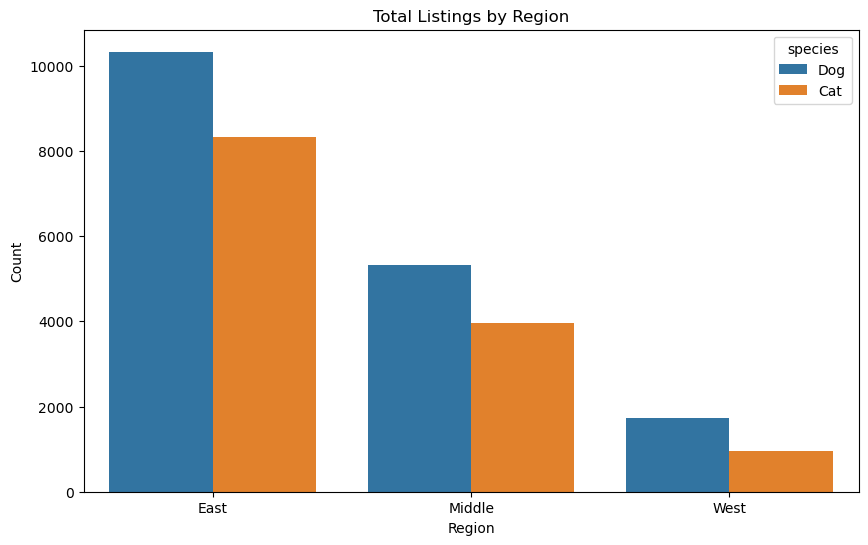

In [137]:
plt.figure(figsize=(10, 6))

sns.barplot(x='region', y='count_total', data=region_ar, hue='species')

plt.title('Total Listings by Region')
plt.ylabel('Count')
plt.xlabel('Region')

plt.show()

Which regions have the most cats and dog adoptions?

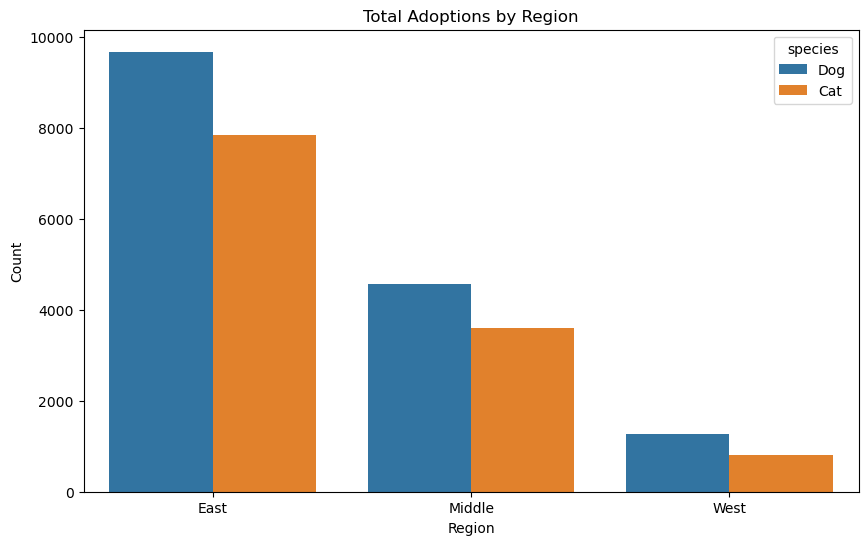

In [138]:
plt.figure(figsize=(10, 6))

sns.barplot(x='region', y='count_adopted', data=region_ar, hue='species')

plt.title('Total Adoptions by Region')
plt.ylabel('Count')
plt.xlabel('Region')

plt.show()

What is the adoption rate by region?

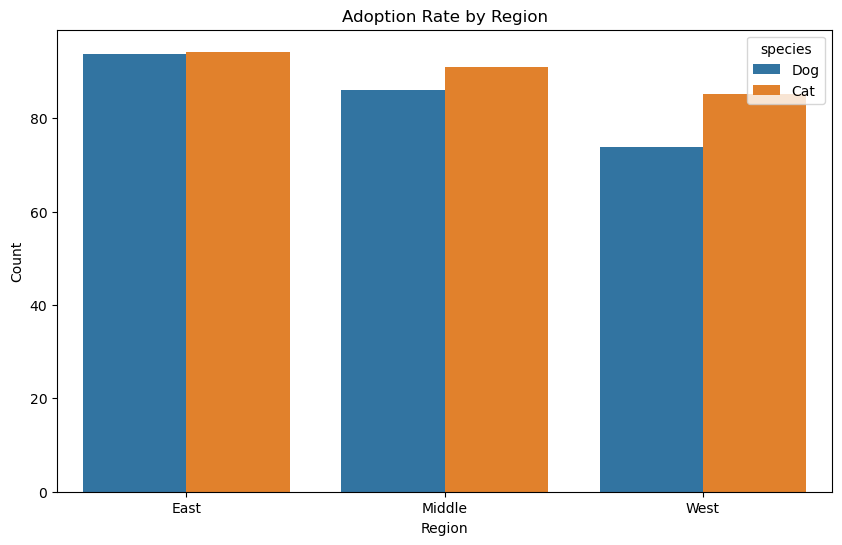

In [133]:
plt.figure(figsize=(10, 6))

sns.barplot(x='region', y='adoption rate %', data=region_ar, hue='species')

plt.title('Adoption Rate by Region')
plt.ylabel('Count')
plt.xlabel('Region')

plt.show()

## Are there specific species and breeds that are more likely to be adopted?

How many different primary breeds are there for cats and dogs?

How many are full breed and how many are mixed?

#### Which breeds are adopted most frequently? What is the adoption rate by breed? 

DOGS

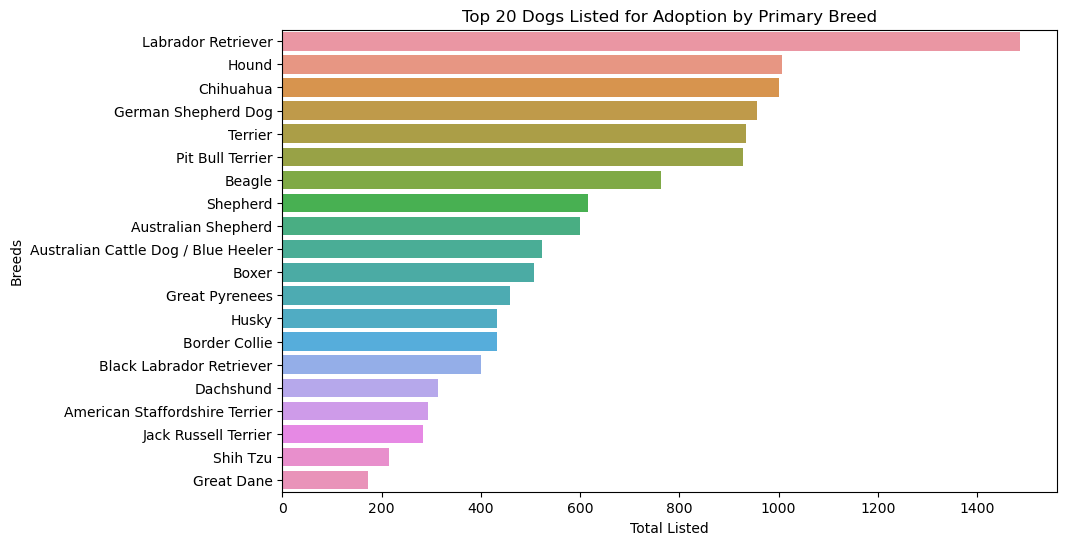

In [145]:
dogs = df[df['species'] == 'Dog']
total_by_breed = dogs.groupby('breeds.primary')['id'].count().reset_index(name='count_total').sort_values('count_total', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='count_total', y='breeds.primary', data=total_by_breed)
plt.xlabel('Total Listed')
plt.ylabel('Breeds')
plt.title('Top 20 Dogs Listed for Adoption by Primary Breed')
plt.show()

# Mixed & Full Breed Dogs
# Labs are the top listed dogs

In [146]:
# Group and count for adopted and total
total_by_breed = dogs.groupby('breeds.primary')['id'].count().reset_index(name='count_total')
adopted_by_breed = adopted_dogs.groupby('breeds.primary')['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
breeds_ar = pd.merge(total_by_breed, adopted_by_breed, on='breeds.primary', how='outer')

# Add new column and calculate adoption rate + round
breeds_ar['adoption rate %'] = round((breeds_ar['count_adopted'] / breeds_ar['count_total']) * 100, 2)
breeds_ar = breeds_ar.sort_values('count_total', ascending=False).head(20) # Sort top 20 most frequently posted
breeds_ar = breeds_ar.sort_values('adoption rate %', ascending=False) # Sort adoption rate %

# Plot in barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='adoption rate %', y='breeds.primary', data=breeds_ar)
plt.xlabel('Adoption Rate (%)')
plt.ylabel('Breeds')
plt.title('Top 20 Most Frequently Listed Dogs by Primary Breed and Adoption Rate %')
plt.show()

breeds_ar


NameError: name 'adopted_dogs' is not defined

In [ ]:
# 
labs_listed = dogs[dogs['breeds.primary'] == 'Labrador Retriever']
labs_listed = labs_listed.groupby('breeds.mixed')['id'].count()
labs_adopted = adopted[adopted['breeds.primary'] == 'Labrador Retriever']
labs_adopted = labs_adopted.groupby('breeds.mixed')['id'].count()
print(labs_listed)
print(labs_adopted)

CATS 

In [ ]:
# Group and count for adopted and total
total_by_breed = cats.groupby('breeds.primary')['id'].count().reset_index(name='count_total')
adopted_by_breed = adopted_cats.groupby('breeds.primary')['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
breeds_ar = pd.merge(total_by_breed, adopted_by_breed, on='breeds.primary', how='outer')

# Add new column and calculate adoption rate + round
breeds_ar['adoption rate %'] = round((breeds_ar['count_adopted'] / breeds_ar['count_total']) * 100, 2)
breeds_ar = breeds_ar.sort_values('count_total', ascending=False).head(20) # Sort top 20 most frequently posted
breeds_ar = breeds_ar.sort_values('adoption rate %', ascending=False) # Sort adoption rate %

# Plot in barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='adoption rate %', y='breeds.primary', data=breeds_ar)
plt.xlabel('Adoption Rate (%)')
plt.ylabel('Breeds')
plt.title('Top 20 Most Frequently Listed Cats and Adoption Rate %')
plt.show()

breeds_ar

## Q2. Does breed mix (full vs mixed) impact the possibility for adoption?

#### What is the distribution of adoption time for full breed vs mixed breed dogs/cats?

In [ ]:
full = dogs[(dogs['breeds.mixed'] == 'False') & (dogs['status'] == 'adopted')]
mixed = dogs[(dogs['breeds.mixed'] == 'True') & (dogs['status'] == 'adopted')]

plt.figure(figsize=(10, 6))

sns.histplot(mixed['adoption_time'], bins=10, color='red', label='Mixed Breeds')
sns.histplot(full['adoption_time'], bins=10, color='blue', label='Full Breed')


plt.title('Distribution of Adoption Time for Mixed Breed vs Full Breed Dogs')
plt.xlabel('Adoption Time (days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('Full Breed', full['id'].count())
print('Mixed Breed', mixed['id'].count())
print(round((full['id'].count() / mixed['id'].count() * 100),2),'% of Dogs Adopted are Full Breed')
# Less full breed dogs

In [ ]:
plt.figure(figsize=(10, 6))

# Plot adopted pets
sns.scatterplot(data=adopted_both, x='published_date', y='adoption_time', hue='species', alpha=0.5)
#sns.scatterplot(data=adopted, x='month_published', y='adoption_time', alpha=0.5, label='Adopted')
# Plt pets not adopted in 2023
#sns.scatterplot(data=available, x='published_date', y='days_available', color='red', alpha=0.5, label='Pets Available')


plt.title('Adoption Time vs Listing Date')
plt.ylabel('Adoption Time (days)')
plt.xlabel('Listing Date')

plt.legend()

plt.show()

# Animals tend to be adopted relatively quickly (between 0-50 days) and adoption time seems to decrease if pets are adopted as time goes on through the year

In [ ]:
full = cats[(cats['breeds.mixed'] == 'False') & (cats['status'] == 'adopted')]
mixed = cats[(cats['breeds.mixed'] == 'True') & (cats['status'] == 'adopted')]

plt.figure(figsize=(10, 6))

sns.histplot(full['adoption_time'], bins=10, color='blue', label='Full Breed')
sns.histplot(mixed['adoption_time'], bins=10, color='red', label='Mixed Breeds')

plt.title('Distribution of Adoption Time for Mixed Breed vs Full Breed Cats')
plt.xlabel('Adoption Time (days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('Full Breed', full['id'].count())
print('Mixed Breed', mixed['id'].count())
print(round((mixed['id'].count() / full['id'].count() * 100),2),'% of Cats Adopted are Mixed Breed')

# More full breed cats

#### What is the adoption rate for full vs mixed breed for cats & dogs?

In [ ]:
# Group
total = dogs.groupby('breeds.mixed')['id'].count().reset_index(name='count_total')
total_adopted = adopted_dogs.groupby('breeds.mixed')['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
breedmix_ar = pd.merge(total, total_adopted, on='breeds.mixed', how='outer')

breedmix_ar['adoption rate %'] = round((breedmix_ar['count_adopted'] / breedmix_ar['count_total']) * 100, 2)

breedmix_ar

In [ ]:
# Group
total = cats.groupby('breeds.mixed')['id'].count().reset_index(name='count_total')
total_adopted = adopted_cats.groupby('breeds.mixed')['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
breedmix_ar = pd.merge(total, total_adopted, on='breeds.mixed', how='outer')

breedmix_ar['adoption rate %'] = round((breedmix_ar['count_adopted'] / breedmix_ar['count_total']) * 100, 2)
breedmix_ar

# relatively small difference - no impact

## Does age, gender, or size impact possibility for adoption?

What is the average adoption speed for age, gender, and size?

#### Dogs

In [ ]:
adopted_dogs = dogs[dogs['status'] == 'adopted']
adopted_dogs = adopted_dogs.groupby('age')['id'].count().reset_index(name='count_adopted')
listed_dogs = dogs.groupby('age')['id'].count().reset_index(name='count_listed')
dogs_ar = pd.merge(adopted_dogs, listed_dogs, on='age', how='outer')
dogs_ar['adoption rate %'] = round((dogs_ar['count_adopted'] / dogs_ar['count_listed']) * 100, 2)
dogs_ar


In [ ]:
adopted_dogs = dogs[dogs['status'] == 'adopted']
adopted_dogs = adopted_dogs.groupby('size')['id'].count().reset_index(name='count_adopted')
listed_dogs = dogs.groupby('size')['id'].count().reset_index(name='count_listed')
dogs_ar = pd.merge(adopted_dogs, listed_dogs, on='size', how='outer')
dogs_ar['adoption rate %'] = round((dogs_ar['count_adopted'] / dogs_ar['count_listed']) * 100, 2)
dogs_ar

In [ ]:
adopted_dogs = dogs[dogs['status'] == 'adopted']
adopted_dogs = adopted_dogs.groupby('gender')['id'].count().reset_index(name='count_adopted')
listed_dogs = dogs.groupby('gender')['id'].count().reset_index(name='count_listed')
dogs_ar = pd.merge(adopted_dogs, listed_dogs, on='gender', how='outer')
dogs_ar['adoption rate %'] = round((dogs_ar['count_adopted'] / dogs_ar['count_listed']) * 100, 2)
dogs_ar

#### Cats

In [ ]:
adopted_cats = cats[cats['status'] == 'adopted']
adopted_cats = adopted_cats.groupby('age')['id'].count().reset_index(name='count_adopted')
listed_cats = cats.groupby('age')['id'].count().reset_index(name='count_listed')
cats_ar = pd.merge(adopted_cats, listed_cats, on='age', how='outer')
cats_ar['adoption rate %'] = round((cats_ar['count_adopted'] / cats_ar['count_listed']) * 100, 2)
cats_ar

In [ ]:
adopted_cats = cats[cats['status'] == 'adopted']
adopted_cats = adopted_cats.groupby('size')['id'].count().reset_index(name='count_adopted')
listed_cats = cats.groupby('size')['id'].count().reset_index(name='count_listed')
cats_ar = pd.merge(adopted_cats, listed_cats, on='size', how='outer')
cats_ar['adoption rate %'] = round((cats_ar['count_adopted'] / cats_ar['count_listed']) * 100, 2)
cats_ar

In [ ]:
adopted_cats = cats[cats['status'] == 'adopted']
adopted_cats = adopted_cats.groupby('gender')['id'].count().reset_index(name='count_adopted')
listed_cats = cats.groupby('gender')['id'].count().reset_index(name='count_listed')
cats_ar = pd.merge(adopted_cats, listed_cats, on='gender', how='outer')
cats_ar['adoption rate %'] = round((cats_ar['count_adopted'] / cats_ar['count_listed']) * 100, 2)
cats_ar

## Are there patterns or trends related to how quickly an cats/dogs are adopted?

What is the average adoption speed for cats vs dogs?

In [ ]:
both.groupby('species')['adoption_time'].mean().reset_index(name='Avg Adoption Speed')

In [ ]:
adopted_cats = cats[cats['status'] == 'adopted']
adopted_dogs = dogs[dogs['status'] == 'adopted']

plt.figure(figsize=(10, 6))

plt.hist(adopted_dogs['adoption_time'], bins=5, edgecolor='black', label='Dogs', color='blue')
plt.hist(adopted_cats['adoption_time'], bins=5, edgecolor='black', label='Cats', color='red')

plt.xlabel('Adoption Time')
plt.ylabel('Frequency')
plt.title('Distribution of Adoption Time Cats vs Dogs')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

sns.kdeplot(adopted_cats['adoption_time'], fill=True, color='red', label='Cats')
sns.kdeplot(adopted_dogs['adoption_time'], fill=True, color='blue', label='Dogs')


plt.title('Adoption Time Distribution Between Cats & Dogs')
plt.xlabel('Adoption Time (days)')
plt.xscale('log')
plt.legend()
plt.show()

#### Does age impact adoption speed?

In [ ]:
both_adopted = both[both['status'] == 'adopted']

avg_adoption_time = both_adopted.groupby(['age', 'species'])['adoption_time'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_adoption_time, x='age', y='adoption_time', hue='species')
plt.title('Average Adoption Time of Cats vs Dogs by Age Group')
plt.xlabel('Age')
plt.ylabel('Average Adoption Time (days)')

plt.show()

avg_adoption_time

In [ ]:
avg_adoption_time = both_adopted.groupby(['gender', 'species'])['adoption_time'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_adoption_time, x='gender', y='adoption_time', hue='species')
plt.title('Average Adoption Time of Cats vs Dogs by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Adoption Time (days)')

plt.show()

avg_adoption_time

In [ ]:
avg_adoption_time = both_adopted.groupby(['size', 'species'])['adoption_time'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_adoption_time, x='size', y='adoption_time', hue='species')
plt.title('Average Adoption Time of Cats vs Dogs by Size')
plt.xlabel('Size')
plt.ylabel('Average Adoption Time (days)')

plt.show()

avg_adoption_time

## Does Seasonality impact adoptions between cats and dogs?

In [ ]:
avg_adoption_time = both_adopted.groupby(['month_status_change', 'species'])['adoption_time'].count().reset_index(name='adoption_time')

plt.figure(figsize=(12, 8))
sns.lineplot(data=avg_adoption_time, x='month_status_change', y='adoption_time', hue='species', marker='o')
plt.title('Dog and Cat Adoptions by Month')
plt.xlabel('Total Number of Adoptions')
plt.ylabel('Month')
plt.xticks(range(1, 13))

plt.show()

#avg_adoption_time

In [ ]:
both.columns

In [ ]:
count_adopted = both_adopted.groupby(['status_change_date', 'species'])['id'].count().reset_index(name='count')

plt.figure(figsize=(12, 8))
sns.lineplot(data=count_adopted, x='status_change_date', y='count', hue='species')
plt.title('Dog and Cat Adoptions by Day')
plt.xlabel('Date')
plt.ylabel('Total Number of Adoptions')
plt.yscale('log')

plt.show()

count_adopted

### Group by week?